# Two-dimensional problem

We propose a two-dimensional problem, that relax to the isolated skyrmion state. The simulated material is FeGe with material parameters:

- $M_\text{s} = 384 \,\text{kA}\,\text{m}^{-1}$
- $A = 8.78 \,\text{pJ}\,\text{m}^{-1}$
- $D = 1.58 \,\text{mJ}\,\text{m}^{-2}$

## Skyrmion state

### Simulation

We simulate a $100 \,\text{nm}$ diametre disk sample with $(1 \,\text{nm}, 1 \,\text{nm}, 1 \,\text{nm})$ discretisation.

2017/11/2 14:25: Calling OOMMF (skyrmion/skyrmion.mif) ... [1.7s]


/usr/local/lib/python3.5/dist-packages/oommfodt/oommfodt.py:114: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.units = dict(zip(columns, units))


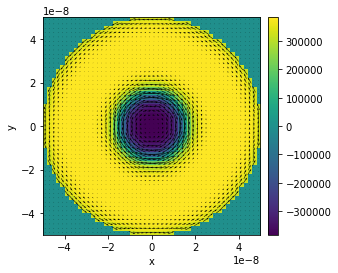

In [52]:
import oommfc as oc
import discretisedfield as df
import numpy as np
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt

# Geometry parameters
d = 100e-9  # disk diametre (nm)
t = 2e-9  # discretisation (nm)

# Material parameters
Ms = 3.84e5  # magnetisation saturation (A/m)
A = 8.78e-12  # exchange energy constant (J/m)
D = 2.58e-3  # DMI energy constant (J/m**2)

mesh = oc.Mesh(p1=(-d/2, -d/2, 0), p2=(d/2, d/2, t), cell=(t, t, t))

system = oc.System(name="skyrmion")
system.hamiltonian = oc.Exchange(A=A) + oc.DMI(D=D, kind='bulk') + oc.UniaxialAnisotropy(K1=0.51e6, u=(0, 0, 1))

def Ms_fun(pos):
    x, y, z = pos
    if (x**2 + y**2)**0.5 < d/2:
        return Ms
    else:
        return 0

def m_init(pos):
    x, y, z = pos
    if (x**2 + y**2)**0.5 < d/4:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

system.m = df.Field(mesh, value=m_init, norm=Ms_fun)

md = oc.MinDriver()
md.drive(system)

system.m.plot_plane('z')

system.m.write('skyrmion.vtk')

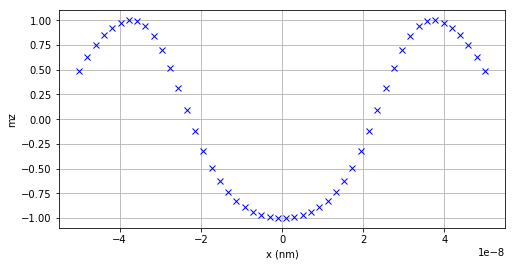

In [53]:
sampled_data = list(system.m.line(p1=(-d/2, 0, 0), p2=(d/2, 0, 0), n=mesh.n[0]))
coordinates, magnetization = list(zip(*sampled_data))

x, _, _ = list(zip(*coordinates))
_, _, mz = list(zip(*magnetization))

plt.figure(figsize=(8, 4))

plt.plot(x, mz_norm, 'bx')
plt.xlabel("x (nm)")
plt.ylabel("mz")
plt.grid()

### Analytic solution

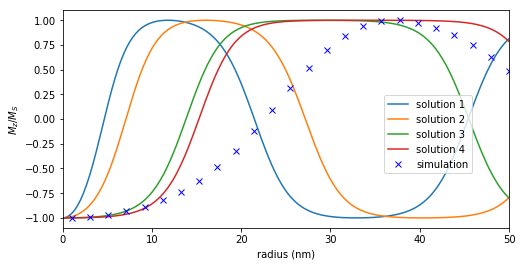

In [54]:
xi = 2*A/D
Delta = np.sqrt(A/K)

r_array = np.linspace(1e-15, d/2, 300)

def ode_2d(theta, r):
    return np.array([theta[1],
                     -theta[1]/r + np.sin(2*theta[0])/2*(1/(r**2)+ K/A) - 2*(np.sin(theta[0])**2)/(xi*r)])

def error(dtheta_guess):
    solution = scipy.integrate.odeint(ode_2d, np.array([np.pi, dtheta_guess/xi]), r_array) 
    return solution[-1,1] - (-1/xi) 

dtheta_guess_range = np.linspace(-10, 0, 1000)

errors = []
for dtheta_guess in dtheta_guess_range:
    errors.append(error(dtheta_guess))

imax = len(dtheta_guess_range)
roots = []
final_solutions = []

for i in range(imax-1):
    if np.sign(errors[i])*np.sign(errors[i+1]) < 0:
        dtheta_0 = scipy.optimize.brentq(error, dtheta_guess_range[i], dtheta_guess_range[i+1])
        roots.append(dtheta_0)
        final_solution = scipy.integrate.odeint(ode_2d, np.array([np.pi, dtheta_0/xi]), r_array)
        final_solutions.append(final_solution[:, 0])        

plt.figure(figsize=(8, 4))
n_roots = len(roots)

for n in range(len(roots)):
    label_string = 'solution {}'.format(n+1) 
    plt.plot(r_array/1e-9, np.cos(final_solutions[n]), label=label_string)
plt.plot(np.array(x)/1e-9, mz_norm, 'bx', label='simulation')
plt.xlim([0, d/2e-9])
plt.xlabel('radius (nm)')
plt.ylabel(r'$M_z/M_S$')
plt.legend(loc=(0.72,0.25))

The simulation output varies with cell size, especially at the transition from -1 to +1 and hence slightly deviates from the semi-analytical solution obtained by solving Rohart-Thiaville's ODE using the shooting method for cell sizes larger than 1 nm.